In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, linregress

In [2]:
df_base = pd.read_csv('promo_order_data.csv')
df_base['trans_date'] = pd.to_datetime(df_base['trans_date'])
device_list = ['Android', 'GCF', 'Macintosh', 'Tablet', 'Windows', 'X11', 'iPhone']

In [3]:
df1 = pd.DataFrame(pd.date_range(min(df_base.trans_date),max(df_base.trans_date)), columns = ['trans_date'])
df1['key'] = 0
df2 = pd.DataFrame(np.arange(24), columns = ['trans_hour'])
df2['key'] = 0
df3 = pd.merge(df1,df2,on = 'key', how = 'outer')
df_base = pd.merge(df3,df_base, on=['trans_date','trans_hour'], how = 'outer')

In [4]:
df_base['name_day'] = df_base['trans_date'].apply(dt.datetime.strftime, args = ['%A'])
df_base['perc_promo_cnt'] = df_base['promo_count']/df_base['orders']
df_base['amount_per_order'] = df_base['amount']/df_base['orders']
df_base['amount_per_customer'] = df_base['amount']/df_base['customers']
df_base['amount_per_vendors'] = df_base['amount']/df_base['vendors']
df_base['order_per_customer'] = df_base['orders']/df_base['customers']
df_base['order_per_vendors'] = df_base['orders']/df_base['vendors']
df_base.replace([np.inf, -np.inf], np.nan, inplace=True)
df_base.fillna(0, inplace = True)
df_base['others'] = df_base['customers'] - (df_base['Android']+df_base['GCF']+df_base['Macintosh']
                                                  +df_base['Tablet']+df_base['Windows']+df_base['X11']+df_base['iPhone'])

df_base['device_base'] = df_base['Android']+df_base['GCF']+df_base['Macintosh']+df_base['Tablet']+df_base['Windows']+df_base['X11']+df_base['iPhone']

In [5]:
df_by_date = df_base.groupby(by = ['trans_date']).sum()
df_by_date.reset_index(drop = False, inplace = True)
# df_by_date.fillna(0, inplace = True)

df_by_date['perc_promo_cnt'] = df_by_date['promo_count']/df_by_date['orders']
df_by_date['amount_per_order'] = df_by_date['amount']/df_by_date['orders']
df_by_date['amount_per_customer'] = df_by_date['amount']/df_by_date['customers']
df_by_date['amount_per_vendors'] = df_by_date['amount']/df_by_date['vendors']
df_by_date['order_per_customer'] = df_by_date['orders']/df_by_date['customers']
df_by_date['order_per_vendors'] = df_by_date['orders']/df_by_date['vendors']

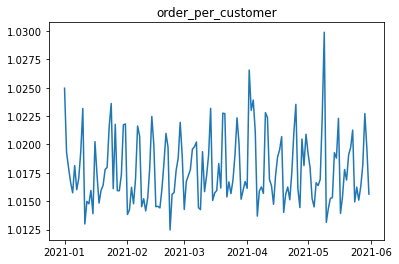

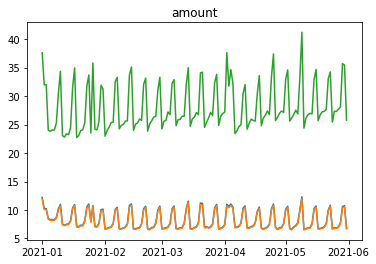

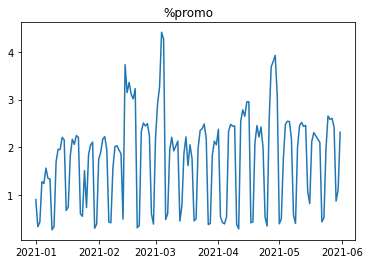

In [6]:
plt.plot(df_by_date.trans_date, df_by_date.order_per_customer)
plt.title('order_per_customer')
plt.show()

plt.plot(df_by_date.trans_date, df_by_date.amount_per_customer, label = 'amount_per_customer')
plt.plot(df_by_date.trans_date, df_by_date.amount_per_order, label = 'amount_per_order')
plt.plot(df_by_date.trans_date, df_by_date.amount_per_vendors, label = 'amount_per_vendor')
plt.title('amount')
plt.show()

plt.plot(df_by_date.trans_date, df_by_date.perc_promo_cnt*100)
plt.title('%promo')
plt.show()

In [7]:
print('Avg order per customer\t: {0:.2f}'.format(sum(df_by_date['orders'])/sum(df_by_date['customers'])))
print('Avg amount per order\t: {0:.2f}'.format(sum(df_by_date['amount'])/sum(df_by_date['orders'])))
print('Avg order per vendor\t: {0:.2f}'.format(sum(df_by_date['orders'])/sum(df_by_date['vendors'])))
print('Avg amount per vendor\t: {0:.2f}'.format(sum(df_by_date['amount'])/sum(df_by_date['vendors'])))
print('Promo count / orders\t: {0:.2f}%'.format(100*sum(df_by_date['promo_count'])/sum(df_by_date['orders'])))

Avg order per customer	: 1.02
Avg amount per order	: 7.55
Avg order per vendor	: 3.58
Avg amount per vendor	: 27.04
Promo count / orders	: 2.07%


In [8]:
def scale(series):
    return np.array(series)/np.linalg.norm(series)

In [9]:
x = np.arange(len(pd.date_range(start = dt.date(2021,2,1), end = dt.date(2021,5,31))))
y = scale(df_by_date.amount)[-len(x):]
slope, intercept, r_value, p_value, std_err =  linregress(x = x, y = y)

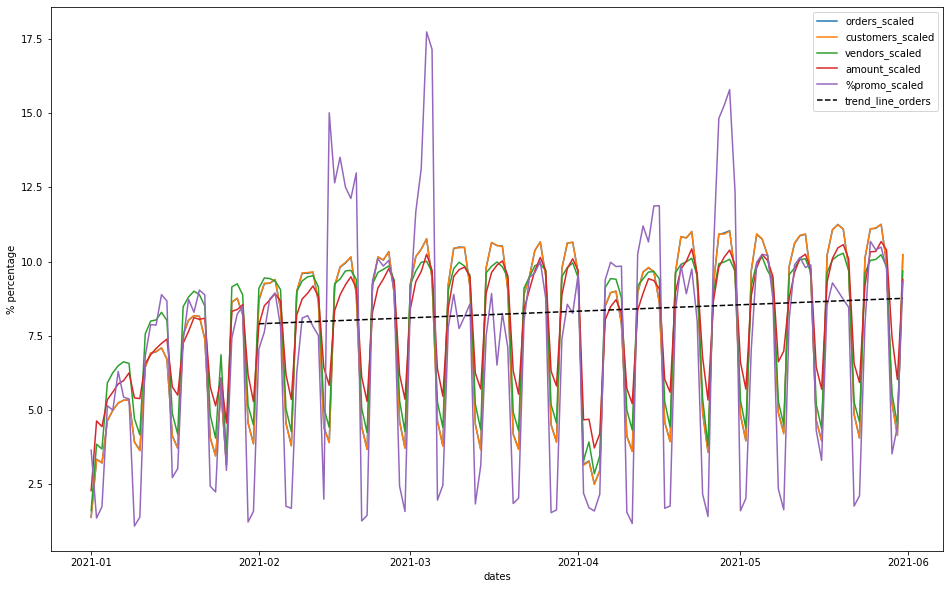

In [10]:
fig1 = plt.figure(figsize = (16,10))
plt.plot(df_by_date.trans_date, scale(df_by_date.orders)*100, label = 'orders_scaled')
plt.plot(df_by_date.trans_date, scale(df_by_date.customers)*100, label = 'customers_scaled')
plt.plot(df_by_date.trans_date, scale(df_by_date.vendors)*100, label = 'vendors_scaled')
plt.plot(df_by_date.trans_date, scale(df_by_date.amount)*100, label = 'amount_scaled')
plt.plot(df_by_date.trans_date, scale(df_by_date.perc_promo_cnt)*100, label = '%promo_scaled')
plt.plot(pd.date_range(start = dt.date(2021,2,1), end = dt.date(2021,5,31)),((slope*x)+intercept)*100, 'k--', label = 'trend_line_orders')
plt.legend()
plt.ylabel('% percentage')
plt.xlabel('dates')
plt.show()

In [11]:
(df_by_date[['customers', 'orders', 'amount', 'vendors', 'perc_promo_cnt']].corr())['perc_promo_cnt'][:-1]

customers    0.840117
orders       0.840324
amount       0.809457
vendors      0.848369
Name: perc_promo_cnt, dtype: float64

In short-term view (daily/weekly granularity), the percentage of promos (%promo) over total orders is highly correlated to total orders which means that additional orders are due to usage of promos (hence why %promo is oscillating with orders/customers/amount). However, in longer time-scale, %promo is nearly constant which means there is almost no long-term effect. This can also mean that new customers acquired during promo periods are not generating consistent orders later which is evident on the slow growth of orders/customers over time. Moreover, significant increases of %promo during certain dates (Feb 14-19, Mar 4-5, Apr 28-30) did not translate to significant increase in orders, customers, and/or amount around said dates. This in turn, probably resulted to lower profit margins due to discounts given.

In [12]:
df_by_hour = df_base.groupby(by = ['trans_hour']).sum()
df_by_hour.fillna(0, inplace = True)

df_by_hour['perc_promo_cnt'] = df_by_hour['promo_count']/df_by_hour['orders']
df_by_hour['amount_per_order'] = df_by_hour['amount']/df_by_hour['orders']
df_by_hour['amount_per_customer'] = df_by_hour['amount']/df_by_hour['customers']
df_by_hour['amount_per_vendors'] = df_by_hour['amount']/df_by_hour['vendors']
df_by_hour['order_per_customer'] = df_by_hour['orders']/df_by_hour['customers']
df_by_hour['order_per_vendors'] = df_by_hour['orders']/df_by_hour['vendors']

df_by_day = df_base.groupby(by = ['name_day']).sum()
df_by_day.fillna(0, inplace = True)

df_by_day['perc_promo_cnt'] = df_by_day['promo_count']/df_by_day['orders']
df_by_day['amount_per_order'] = df_by_day['amount']/df_by_day['orders']
df_by_day['amount_per_customer'] = df_by_day['amount']/df_by_day['customers']
df_by_day['amount_per_vendors'] = df_by_day['amount']/df_by_day['vendors']
df_by_day['order_per_customer'] = df_by_day['orders']/df_by_day['customers']
df_by_day['order_per_vendors'] = df_by_day['orders']/df_by_day['vendors']

In [13]:
custom_sort = {'Sunday':0,'Monday':1,'Tuesday':2,'Wednesday':3,'Thursday':4,'Friday':5,'Saturday':6}
df_by_day.sort_values(by = ['name_day'], key=lambda x: x.map(custom_sort), inplace = True)

In [14]:
display(df_by_hour.head(7))
display(df_by_hour.tail(7))

display(df_by_day)

,key,customers,vendors,orders,amount,promo_count,promo_amount,Android,GCF,Macintosh,...,Blacklisted,Not Blacklisted,perc_promo_cnt,amount_per_order,amount_per_customer,amount_per_vendors,order_per_customer,order_per_vendors,others,device_base
trans_hour,,,,,,,,,,,,,,,,,,,,,
0,0,4.0,4.0,4.0,100.00,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.000000,25.000000,25.000000,25.000000,1.000000,1.000000,2.0,2.0
1,0,2.0,2.0,2.0,200.00,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.000000,100.000000,100.000000,100.000000,1.000000,1.000000,0.0,2.0
2,0,6.0,6.0,6.0,220.00,0.0,0.0,0.0,0.0,0.0,...,0.0,6.0,0.000000,36.666667,36.666667,36.666667,1.000000,1.000000,4.0,2.0
3,0,2.0,2.0,2.0,100.00,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.000000,50.000000,50.000000,50.000000,1.000000,1.000000,0.0,2.0
4,0,12.0,12.0,12.0,96.00,0.0,0.0,0.0,0.0,0.0,...,0.0,12.0,0.000000,8.000000,8.000000,8.000000,1.000000,1.000000,12.0,0.0
5,0,14582.0,5424.0,14654.0,104431.62,70.0,0.0,1000.0,170.0,2.0,...,2.0,14580.0,0.004777,7.126492,7.161680,19.253617,1.004938,2.701696,8492.0,6090.0
6,0,224750.0,58964.0,227490.0,1601422.86,1686.0,0.0,13396.0,3386.0,72.0,...,8.0,224742.0,0.007411,7.039531,7.125352,27.159332,1.012191,3.858117,126820.0,97930.0


,key,customers,vendors,orders,amount,promo_count,promo_amount,Android,GCF,Macintosh,...,Blacklisted,Not Blacklisted,perc_promo_cnt,amount_per_order,amount_per_customer,amount_per_vendors,order_per_customer,order_per_vendors,others,device_base
trans_hour,,,,,,,,,,,,,,,,,,,,,
17,0,3820.0,2844.0,3878.0,93371.36,90.0,0.0,326.0,546.0,16.0,...,4.0,3816.0,0.023208,24.077194,24.442764,32.830999,1.015183,1.363572,1256.0,2564.0
18,0,3212.0,2338.0,3260.0,134913.58,76.0,0.0,198.0,914.0,40.0,...,4.0,3208.0,0.023313,41.384534,42.002983,57.704696,1.014944,1.394354,842.0,2370.0
19,0,2372.0,1716.0,2402.0,98449.80,60.0,0.0,124.0,700.0,22.0,...,2.0,2370.0,0.024979,40.986595,41.504975,57.371678,1.012648,1.399767,586.0,1786.0
20,0,886.0,708.0,898.0,34545.14,30.0,0.0,56.0,342.0,8.0,...,0.0,886.0,0.033408,38.468976,38.990000,48.792571,1.013544,1.268362,150.0,736.0
21,0,178.0,164.0,178.0,7329.26,6.0,0.0,6.0,76.0,0.0,...,0.0,178.0,0.033708,41.175618,41.175618,44.690610,1.000000,1.085366,40.0,138.0
22,0,38.0,30.0,38.0,1155.76,0.0,0.0,18.0,10.0,0.0,...,0.0,38.0,0.000000,30.414737,30.414737,38.525333,1.000000,1.266667,4.0,34.0
23,0,8.0,8.0,8.0,245.00,0.0,0.0,2.0,0.0,0.0,...,0.0,8.0,0.000000,30.625000,30.625000,30.625000,1.000000,1.000000,4.0,4.0


,key,trans_hour,customers,vendors,orders,amount,promo_count,promo_amount,Android,GCF,...,Blacklisted,Not Blacklisted,perc_promo_cnt,amount_per_order,amount_per_customer,amount_per_vendors,order_per_customer,order_per_vendors,others,device_base
name_day,,,,,,,,,,,,,,,,,,,,,
Sunday,0,6072,241604.0,76598.0,246774.0,2628073.76,1662.0,0.0,11572.0,6910.0,...,42.0,241562.0,0.006735,10.649719,10.877609,34.309953,1.021399,3.221677,141454.0,100150.0
Monday,0,6072,555906.0,156812.0,564142.0,3859968.32,11408.0,0.0,30320.0,8304.0,...,60.0,555846.0,0.020222,6.842193,6.943563,24.615261,1.014815,3.597569,352468.0,203438.0
Tuesday,0,5796,581544.0,157038.0,590508.0,4009242.60,14324.0,0.0,31886.0,8744.0,...,46.0,581498.0,0.024257,6.789481,6.894135,25.530398,1.015414,3.760287,370838.0,210706.0
Wednesday,0,5796,604730.0,164654.0,614612.0,4235369.82,14704.0,0.0,34310.0,9212.0,...,42.0,604688.0,0.023924,6.891128,7.003737,25.722848,1.016341,3.732749,381804.0,222926.0
Thursday,0,5796,605350.0,164472.0,615342.0,4309922.38,15638.0,0.0,34982.0,9360.0,...,38.0,605312.0,0.025414,7.004109,7.119720,26.204596,1.016506,3.741318,380562.0,224788.0
Friday,0,6072,525182.0,154664.0,534720.0,4108141.92,12508.0,0.0,31374.0,10032.0,...,50.0,525132.0,0.023392,7.682791,7.822320,26.561720,1.018161,3.457301,318774.0,206408.0
Saturday,0,6072,286384.0,91022.0,292402.0,2946279.68,1482.0,0.0,14486.0,7736.0,...,28.0,286356.0,0.005068,10.076127,10.287864,32.368874,1.021014,3.212432,165704.0,120680.0


Due to low number of transactions on trans_hour < 5 and trans_hours > 21 over a 5-month period data, these hours will be excluded from the analysis thereinafter.

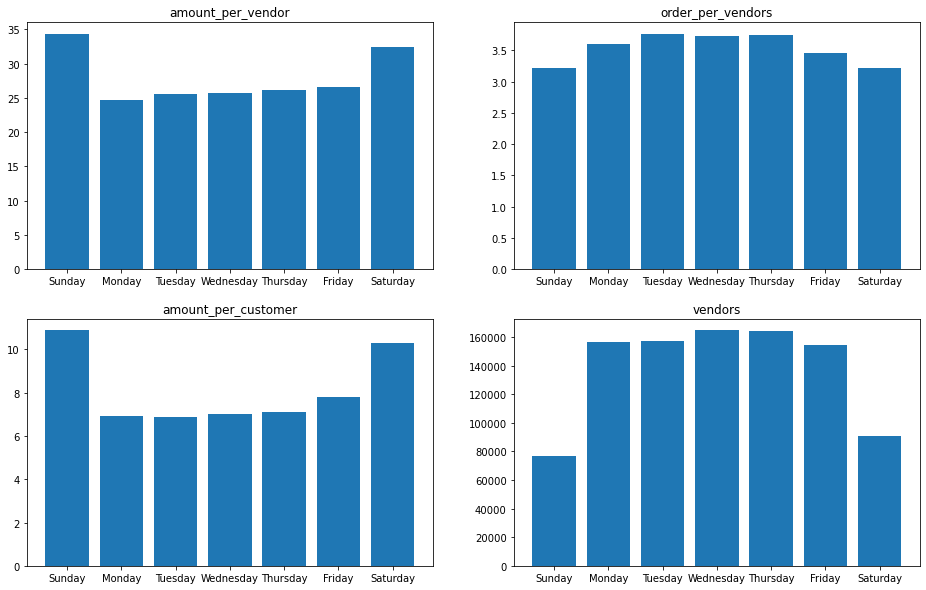

In [15]:
fig, ax = plt.subplots(2,2, figsize = (16,10))
ax[0,0].bar(df_by_day.index, df_by_day.amount_per_vendors)
ax[0,0].set_title('amount_per_vendor')
ax[0,1].bar(df_by_day.index, df_by_day.order_per_vendors)
ax[0,1].set_title('order_per_vendors')
ax[1,0].bar(df_by_day.index, df_by_day.amount_per_customer)
ax[1,0].set_title('amount_per_customer')
ax[1,1].bar(df_by_day.index, df_by_day.vendors)
ax[1,1].set_title('vendors')
plt.show()

In [16]:
diff_spend_week_day = df_by_day[df_by_day.index.isin(['Sunday','Saturday'])].amount_per_customer.mean() - df_by_day[~df_by_day.index.isin(['Sunday','Saturday'])].amount_per_customer.mean()
print('Customers who order-ahead during weekends spend on average {0:.2f} AUD more than any other day of the week despite a.) low number of promos being offered (may be due to drop in vendors) and b.) minimal drop in number of order per vendor on weekends.'.format(diff_spend_week_day))

Customers who order-ahead during weekends spend on average 3.43 AUD more than any other day of the week despite a.) low number of promos being offered (may be due to drop in vendors) and b.) minimal drop in number of order per vendor on weekends.


,Android,GCF,Macintosh,Tablet,Windows,X11,iPhone
name_day,,,,,,,
Sunday,4.789656,2.860052,0.110098,0.081124,0.101820,0.373338,33.136041
Monday,5.454160,1.493778,0.108651,0.050728,0.222700,0.265513,29.000227
Tuesday,5.482990,1.503584,0.101798,0.048836,0.255183,0.247961,28.591818
Wednesday,5.673606,1.523324,0.104509,0.051924,0.258628,0.259951,28.991781
Thursday,5.778806,1.546213,0.105394,0.053192,0.246139,0.279508,29.124308
Friday,5.973929,1.910195,0.111961,0.070833,0.254388,0.326744,30.654135
Saturday,5.058243,2.701268,0.120118,0.069836,0.120118,0.369434,33.700207


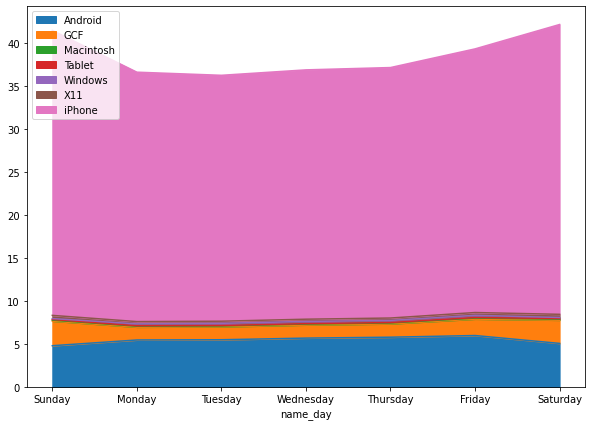

In [17]:
display(df_by_day[device_list].divide(df_by_day.customers, axis = 0)*100)
(df_by_day[device_list].divide(df_by_day.customers, axis = 0)*100).plot(kind = 'area', figsize=(10,7))
plt.legend(loc=2)
plt.show()

In [18]:
gcf_we = df_by_day[df_by_day.index.isin(['Sunday','Saturday'])]['GCF'].divide(df_by_day[df_by_day.index.isin(['Sunday','Saturday'])].customers, axis = 0).mean()
gcf_wd = df_by_day[~df_by_day.index.isin(['Sunday','Saturday'])]['GCF'].divide(df_by_day[~df_by_day.index.isin(['Sunday','Saturday'])].customers, axis = 0).mean()
ip_we = df_by_day[df_by_day.index.isin(['Sunday','Saturday'])]['iPhone'].divide(df_by_day[df_by_day.index.isin(['Sunday','Saturday'])].customers, axis = 0).mean()
ip_wd = df_by_day[~df_by_day.index.isin(['Sunday','Saturday'])]['iPhone'].divide(df_by_day[~df_by_day.index.isin(['Sunday','Saturday'])].customers, axis = 0).mean()

In [31]:
print('We see increase in number of customers ordering through Google Food Ordering and also slight increase in iPhone users on weekends ({0:.2f}% and {1:.2f}% respectively) versus any other day of the week from the same device. Based from the table above, we also see an increase in ordering of Tablet and Linux/CrOS users on weekends but the numbers are insignificant.'.format(100*(gcf_we - gcf_wd)/gcf_wd,100*(ip_we-ip_wd)/ip_wd))

We see increase in number of customers ordering through Google Food Ordering and also slight increase in iPhone users on weekends (74.29% and 14.16% respectively) versus any other day of the week from the same device. Based from the table above, we also see an increase in ordering of Tablet and Linux/CrOS users on weekends but the numbers are insignificant.


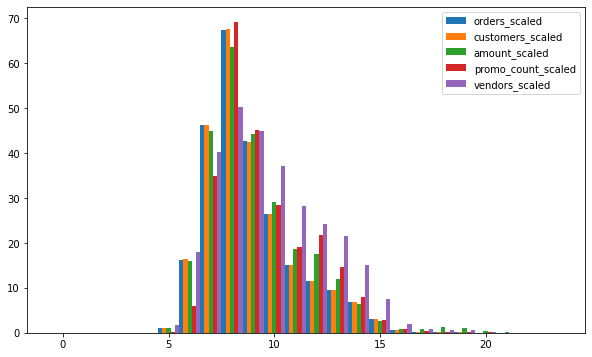

In [20]:
fig1 = plt.figure(figsize = (10,6))
width = 0.2

plt.bar(df_by_hour.index-(2*width), scale(df_by_hour.orders)*100, width = width, label = 'orders_scaled')
plt.bar(df_by_hour.index-width, scale(df_by_hour.customers)*100, width = width, label = 'customers_scaled')
plt.bar(df_by_hour.index, scale(df_by_hour.amount)*100, width = width, label = 'amount_scaled')
plt.bar(df_by_hour.index+width, scale(df_by_hour.promo_count)*100, width = width, label = 'promo_count_scaled')
plt.bar(df_by_hour.index+(2*width), scale(df_by_hour.vendors)*100, width = width, label = 'vendors_scaled')

plt.legend()
plt.show()

In [32]:
print('Graph above shows most of the orders ({0:.2f}% of total orders for the day) happen between 7am to 9am with peak at 8 am.'.format(100*df_by_hour[(df_by_hour.index>=7)&(df_by_hour.index<=9)].orders.sum()/df_by_hour.orders.sum()))

Graph above shows most of the orders (63.09% of total orders for the day) happen between 7am to 9am with peak at 8 am.


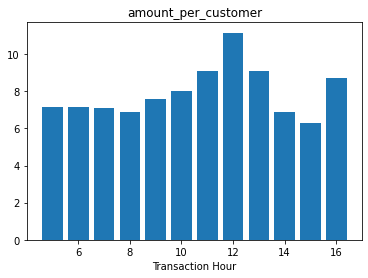

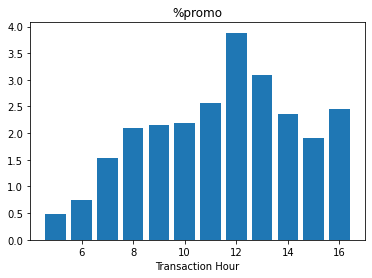

In [22]:
plt.bar(df_by_hour[(df_by_hour.index >= 5) & (df_by_hour.index <= 16)].index
        , df_by_hour[(df_by_hour.index >= 5) & (df_by_hour.index <= 16)].amount_per_customer)

plt.title('amount_per_customer')
plt.xlabel('Transaction Hour')
plt.show()

plt.bar(df_by_hour[(df_by_hour.index >= 5) & (df_by_hour.index <= 16)].index
        , df_by_hour[(df_by_hour.index >= 5) & (df_by_hour.index <= 16)].perc_promo_cnt*100)

plt.title('%promo')
plt.xlabel('Transaction Hour')
plt.show()

In [23]:
pearsonr(df_base['amount_per_customer'], df_base['perc_promo_cnt'])

(0.07011469313681226, 2.3933914183239643e-05)

We see uniform amount per customer from 5am to 4pm with peak at lunch time (12nn). The same uptick at 12nn can also be seen for %promo (almost uniform everywhere else from 8am to 4pm). Since the correlation between the two is very low, nothing can be said between the relationship of the two variables with great certainty. It could be that amount spending during lunch time is, on most occasions, higher compared to other meals at any other.

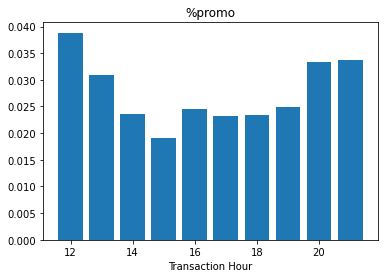

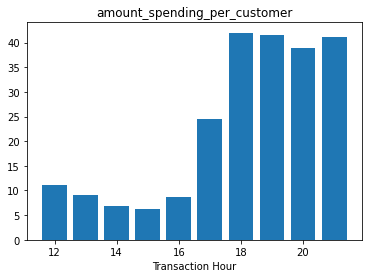

In [24]:
plt.bar(df_by_hour[(df_by_hour.index >= 12) & (df_by_hour.index <= 21)].index
        , df_by_hour[(df_by_hour.index >= 12) & (df_by_hour.index <= 21)].perc_promo_cnt)

plt.title('%promo')
plt.xlabel('Transaction Hour')
plt.show()

plt.bar(df_by_hour[(df_by_hour.index >= 12) & (df_by_hour.index <= 21)].index
        , df_by_hour[(df_by_hour.index >= 12) & (df_by_hour.index <= 21)].amount_per_customer)

plt.title('amount_spending_per_customer')
plt.xlabel('Transaction Hour')
plt.show()

In [25]:
diff_spend_hour = df_by_hour[df_by_hour.index >= 17].amount_per_customer.mean() - df_by_hour[df_by_hour.index < 17].amount_per_customer.mean()
print('Customers who order-ahead between late afternoon (5pm) to evening (9pm) spend on average {0:.2f} AUD more than any other time of the day the week.'.format(diff_spend_hour))

Customers who order-ahead between late afternoon (5pm) to evening (9pm) spend on average 17.08 AUD more than any other time of the day the week.


,Android,GCF,Macintosh,Tablet,Windows,X11,iPhone
trans_hour,,,,,,,
5,6.857770,1.165821,0.013716,0.000000,0.013716,0.288026,33.424770
6,5.960400,1.506563,0.032036,0.009789,0.076529,0.302558,35.684983
7,5.108466,1.442650,0.087844,0.057618,0.103586,0.261642,30.577123
8,5.106109,1.295564,0.098580,0.038181,0.162431,0.239656,27.991596
9,5.788450,1.592928,0.100693,0.061648,0.214057,0.238374,29.326525
10,5.996718,2.031209,0.129944,0.120584,0.294027,0.283015,31.818232
11,6.179396,2.431206,0.126485,0.076277,0.472144,0.351453,32.539345
12,6.365676,3.272064,0.221792,0.048437,0.541733,0.458879,30.594504
13,6.068079,2.661120,0.166415,0.042360,0.428139,0.372163,27.416036


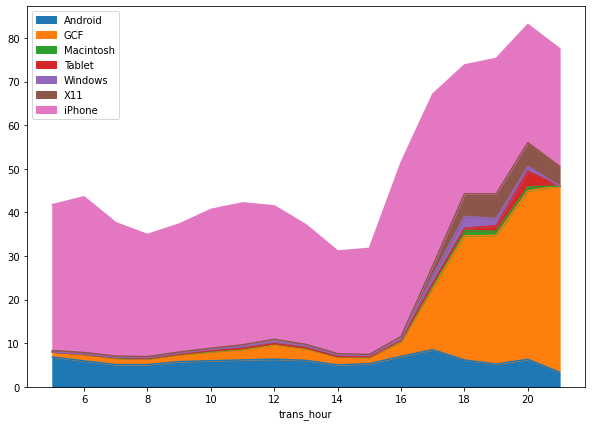

In [26]:
display(df_by_hour[(df_by_hour.index>=5)&(df_by_hour.index<=21)][device_list].divide(
    df_by_hour[(df_by_hour.index>=5)&(df_by_hour.index<=21)].customers, axis = 0)*100)

(df_by_hour[(df_by_hour.index>=5)&(df_by_hour.index<=21)][device_list].divide(
    df_by_hour[(df_by_hour.index>=5)&(df_by_hour.index<=21)].customers, axis = 0)*100).plot.area(figsize=(10,7))
plt.legend(loc=2)
plt.show()

Graph above shows significant increase in Google Food ordering from 5pm to 9pm. We also see slight increase in Linux/CrOS and Tablet users.

In [27]:
full_corr_hour = []
full_sig_hour = []
for j in device_list:
    corr = pearsonr(df_base.amount_per_customer, (df_base[j].divide(df_base.device_base, axis = 0)).fillna(0))
    full_corr_hour.append(corr[0])
    full_sig_hour.append(corr[1])
    
pd.DataFrame(full_corr_hour, index = device_list).T

,Android,GCF,Macintosh,Tablet,Windows,X11,iPhone
0,0.117458,0.626095,0.151758,0.088518,0.205507,0.32442,0.145745


Table above shows high correlation of Google Food Ordering to amount per customer/orders. As such, it can be inferred that customers using Google Food Ordering platform is inherently spending higher amount per order than other users. This is also aligned with previous observation that users of the same platform are driving the amount of spending per customer between late afternoon and evening and during weekends.

In [28]:
# gcf_eve = df_by_hour[(df_by_hour.index>=17)&(df_by_hour.index<=21)]['GCF'].divide(
#     df_by_hour[(df_by_hour.index>=17)&(df_by_hour.index<=21)].customers, axis = 0).mean()
# gcf_morn = df_by_hour[(df_by_hour.index>=5)&(df_by_hour.index<=16)]['GCF'].divide(
#     df_by_hour[(df_by_hour.index>=5)&(df_by_hour.index<=16)].customers, axis = 0).mean()

# 100*(gcf_eve-gcf_morn)/gcf_morn

In [29]:
(df_base[['Android', 'GCF', 'Macintosh', 'Tablet', 'Windows', 'X11', 'iPhone','perc_promo_cnt']].corr())['perc_promo_cnt'][:-1]

Android      0.071512
GCF          0.072552
Macintosh    0.072531
Tablet       0.046582
Windows      0.115658
X11          0.070345
iPhone       0.058217
Name: perc_promo_cnt, dtype: float64

As can be seen from above, there is no correlation between promo usage and the device/platform the customer is using.

In [30]:
(df_base[['Android', 'GCF', 'Macintosh', 'Tablet', 'Windows', 'X11', 'iPhone','Blacklisted']].corr())['Blacklisted'][:-1]

Android      0.199327
GCF          0.221316
Macintosh    0.185511
Tablet       0.146091
Windows      0.187686
X11          0.195478
iPhone       0.201031
Name: Blacklisted, dtype: float64

Series above show weak correlation between device/platform users and Blacklisted customers. As can be seen from the results, nothing can be inferred as of now as the correlation are almost the same across devices.